In [1]:
# Load all necessary packages
import sys
import numpy as np
import pandas as pd

sys.path.append("../")
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
                import load_preproc_data_adult, load_preproc_data_compas

from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from variable_cep import CalibratedEqOddsPostprocessing #modified for varying weight
from variable_cep import normed_rates
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

pip install 'aif360[AdversarialDebiasing]'


In [2]:
## import dataset - use compas
dataset_used = "compas" # "adult", "german", "compas"
protected_attribute_used = 2 # 1, 2

In [3]:
# code to identify the protected attributes from all of the dataset features
if dataset_used == "adult":
    dataset_orig = AdultDataset()
#     dataset_orig = load_preproc_data_adult()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
    
elif dataset_used == "german":
    dataset_orig = GermanDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
    
elif dataset_used == "compas":
#     dataset_orig = CompasDataset()
    dataset_orig = load_preproc_data_compas()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]  

In [4]:
#random seed for calibrated equal odds prediction
randseed = 12345679 

#train validation&test split
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.6], shuffle=True)

In [5]:
# Placeholder for predicted and transformed datasets
dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)

# Logistic regression classifier and predictions for training data
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
lmod = LogisticRegression() #logregression

#fit original model
lmod.fit(X_train, y_train)

fav_idx = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]
y_train_pred_prob = lmod.predict_proba(X_train)[:,fav_idx]

# Prediction probs for training data
class_thresh = 0.5
dataset_orig_train_pred.scores = y_train_pred_prob.reshape(-1,1)

y_train_pred = np.zeros_like(dataset_orig_train_pred.labels)
y_train_pred[y_train_pred_prob >= class_thresh] = dataset_orig_train_pred.favorable_label
y_train_pred[~(y_train_pred_prob >= class_thresh)] = dataset_orig_train_pred.unfavorable_label
dataset_orig_train_pred.labels = y_train_pred

In [6]:
#
#
#
# set up tradeoff cost-benefit calculation
include = False
N_reps = 10
N_values = 500

pbar = tqdm(total=(N_reps*N_values))

negs = []
accs = []
fps = []
fns = []

privileged_options = [True,False,None]

#whether to include all fp and all fn cost functions (True)
if include == True:
    n_range = np.linspace(0.00,1.00,N_values)
if include == False:
    n_range = np.linspace(0.01,0.99,N_values)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [7]:
#set up equalized odds processing
cpp = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                        unprivileged_groups = unprivileged_groups,
                                        cost_constraint='specified',
                                        seed=randseed,NP_rate=(None,None))

In [8]:
dataset_orig_valid_pred,dataset_orig_test_pred, dataset_new_valid_pred, dataset_new_test_pred = None,None,None,None
for neg in n_range:
    negative_val = neg
    positive_val = 1.0 - negative_val

    NP = (negative_val,positive_val)
    cpp.set_NP(NP)

    #should be able to refit


    normed_p,normed_n = normed_rates(NP[1],NP[0])

    gfnr, gfpr, acc = np.zeros(3),np.zeros(3),np.zeros(3)

    del dataset_orig_valid_pred
    
    split = False
        
    for repeat in range(N_reps):

        if (N_reps == 1) and (split == True):
            #If there's only 1 repeat then we use the same validation/test split for each
            pass
        else:
            ##########

            # New Validation/test set reshuffle and prediction for each
            if split == True:
                del dataset_orig_valid_pred
                del dataset_orig_test_pred
                del dataset_new_valid_pred
                del dataset_new_test_pred

            dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)#validation_test split
            dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
            dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)

            dataset_new_valid_pred = dataset_orig_valid.copy(deepcopy=True)
            dataset_new_test_pred = dataset_orig_test.copy(deepcopy=True)

            X_valid = scale_orig.transform(dataset_orig_valid.features)
            y_valid_pred_prob = lmod.predict_proba(X_valid)[:,fav_idx]

            X_test = scale_orig.transform(dataset_orig_test.features)
            y_test_pred_prob = lmod.predict_proba(X_test)[:,fav_idx]

            dataset_orig_valid_pred.scores = y_valid_pred_prob.reshape(-1,1)
            dataset_orig_test_pred.scores = y_test_pred_prob.reshape(-1,1)

            y_valid_pred = np.zeros_like(dataset_orig_valid_pred.labels)
            y_valid_pred[y_valid_pred_prob >= class_thresh] = dataset_orig_valid_pred.favorable_label
            y_valid_pred[~(y_valid_pred_prob >= class_thresh)] = dataset_orig_valid_pred.unfavorable_label
            dataset_orig_valid_pred.labels = y_valid_pred
                
            y_test_pred = np.zeros_like(dataset_orig_test_pred.labels)
            y_test_pred[y_test_pred_prob >= class_thresh] = dataset_orig_test_pred.favorable_label
            y_test_pred[~(y_test_pred_prob >= class_thresh)] = dataset_orig_test_pred.unfavorable_label
            dataset_orig_test_pred.labels = y_test_pred
            split=True

        # Odds equalizing post-processing algorithm

        ##########


        # Learn parameters to equalize odds and apply to create a new dataset
        cpp = cpp.fit(dataset_orig_valid, dataset_orig_valid_pred)

        dataset_transf_valid_pred = cpp.predict(dataset_orig_valid_pred)
        dataset_transf_test_pred = cpp.predict(dataset_orig_test_pred)

        cm_transf_valid = ClassificationMetric(dataset_orig_valid, dataset_transf_valid_pred,
                                    unprivileged_groups=unprivileged_groups,
                                    privileged_groups=privileged_groups)

        cm_transf_test = ClassificationMetric(dataset_orig_test, dataset_transf_test_pred,
                                    unprivileged_groups=unprivileged_groups,
                                    privileged_groups=privileged_groups)

        #cm_transf_test.difference
        
        for idx,PR in enumerate(privileged_options):
            gfnr[idx] += cm_transf_test.false_negative_rate(privileged=PR)
            gfpr[idx] += cm_transf_test.false_positive_rate(privileged=PR)
            result = cm_transf_test.accuracy(privileged=PR)
            acc[idx] += float(result)

        pbar.update(1)

    fns.append(gfnr/N_reps)
    fps.append(gfpr/N_reps)
    accs.append(acc/N_reps)
    negs.append(neg)

100%|██████████| 5000/5000 [11:59<00:00,  3.42it/s]

In [9]:
# plot results from fns, fps, accs, negs for different groups
collapse = lambda param, idx : [v[idx] for v in param]

getnames = {None:"full data", True:"privileged", False:"unprivileged"}

percentchange = lambda result: [100*((i-result[0])/result[0]) for i in result]

idx,PR = 2,None
maximised_accuracy = max(collapse(accs,idx))
maximised_idx = collapse(accs,idx).index(maximised_accuracy)
percentmax = lambda result: [100*((i-result[maximised_idx])/result[maximised_idx]) for i in result]

In [19]:
maximised_value_idx = lambda prop, idx : collapse(prop,idx).index(max(collapse(prop,idx)))
idx = 2
values = ['min false positive','min false negative', 'max accuracy']
for idv,prop in enumerate([-1*np.array(fps),-1*np.array(fns),accs]):
    print("\n"+values[idv])
    maxi = maximised_value_idx(prop,idx)


    print("false postive: {}".format(round(collapse(fps,idx)[maxi],3)))
    print("false negative: {}".format(round(collapse(fns,idx)[maxi],3)))
    print("accs: {}".format(round(collapse(accs,idx)[maxi],3)))



min false positive
false postive: 0.421
false negative: 0.279
accs: 0.65

min false negative
false postive: 0.532
false negative: 0.16
accs: 0.653

max accuracy
false postive: 0.438
false negative: 0.217
accs: 0.672


Text(0.5, 1.0, 'compas1d full data\nmax_acc=0.6723, fn_cost=0.825')

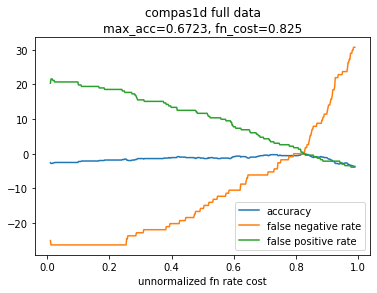

In [20]:
#show accuracy, fp,fn % change from max accuracy for whole model


plt.figure()
plt.plot(negs,percentmax(collapse(accs,idx)),label='accuracy')
plt.plot(negs,percentmax(collapse(fns,idx)),label='false negative rate')
plt.plot(negs,percentmax(collapse(fps,idx)),label='false positive rate')
plt.xlabel('unnormalized fn rate cost')

plt.legend()
plt.title('compas1d {}\nmax_acc={}, fn_cost={}'.format(getnames[PR],round(maximised_accuracy,4),round(negs[maximised_idx],4)))

Text(0.5, 1.0, 'compas1d full data\nmax_acc=0.6723, fn_cost=0.825')

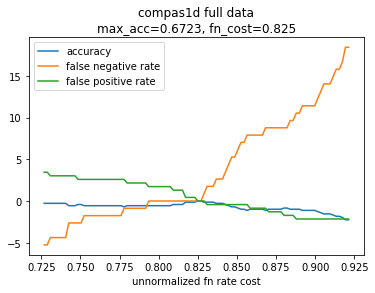

In [21]:
#show accuracy, fp,fn values % change around the max accuracy for whole model
width = 50
if maximised_idx < width:
    minv,maxv = 0,2*maximised_idx
else:
    minv,maxv = maximised_idx-width,maximised_idx+width

idx,PR = 2,None

diceup = lambda lst : lst[minv:maxv]

plt.figure()
plt.plot(diceup(negs),diceup(percentmax(collapse(accs,idx))),label='accuracy')
plt.plot(diceup(negs),diceup(percentmax(collapse(fns,idx))),label='false negative rate')
plt.plot(diceup(negs),diceup(percentmax(collapse(fps,idx))),label='false positive rate')
plt.xlabel('unnormalized fn rate cost')

plt.legend()
plt.title('compas1d {}\nmax_acc={}, fn_cost={}'.format(getnames[PR],round(maximised_accuracy,4),round(negs[maximised_idx],4)))

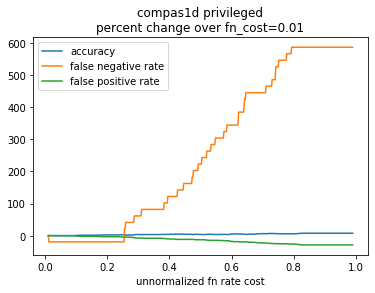

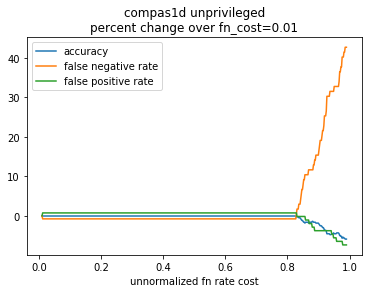

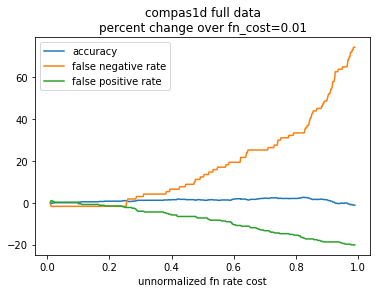

In [22]:
#show accuracy, fp,fn % change from the start
for idx,PR in enumerate(privileged_options):
    cost_0 = negs[0]
    plt.figure()
    plt.plot(negs,percentchange(collapse(accs,idx)),label='accuracy')
    plt.plot(negs,percentchange(collapse(fns,idx)),label='false negative rate')
    plt.plot(negs,percentchange(collapse(fps,idx)),label='false positive rate')
    plt.xlabel('unnormalized fn rate cost')

    plt.legend()
    plt.title('compas1d {}\npercent change over fn_cost={}'.format(getnames[PR],cost_0))

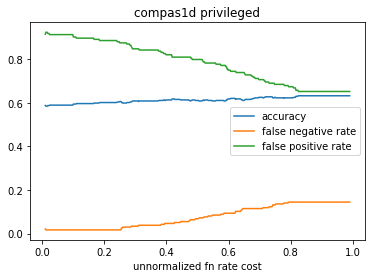

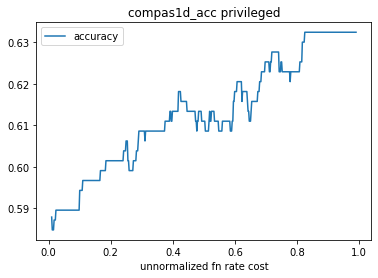

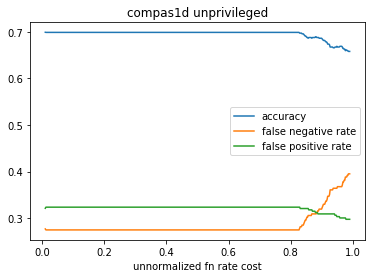

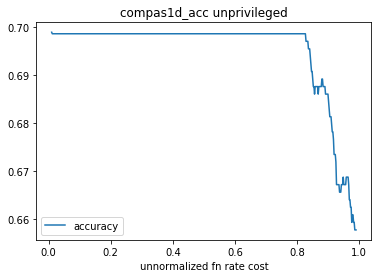

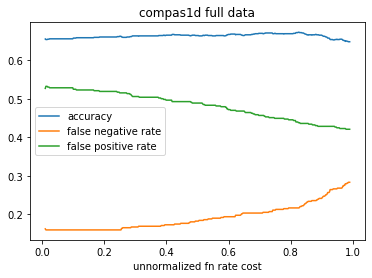

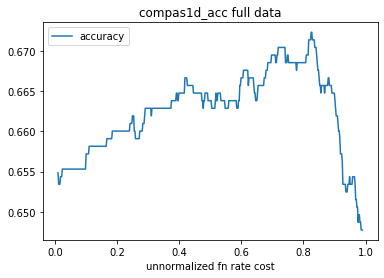

In [23]:
#show raw accuracy,fp,fn
for idx,PR in enumerate(privileged_options):
    plt.figure()
    plt.plot(negs,collapse(accs,idx),label='accuracy')
    plt.plot(negs,collapse(fns,idx),label='false negative rate')
    plt.plot(negs,collapse(fps,idx),label='false positive rate')
    plt.xlabel('unnormalized fn rate cost')

    plt.legend()
    plt.title('compas1d {}'.format(getnames[PR]))

    plt.figure()
    plt.plot(negs,collapse(accs,idx),label='accuracy')
    plt.xlabel('unnormalized fn rate cost')
    plt.legend()
    plt.title('compas1d_acc {}'.format(getnames[PR]))